In [1]:
#For Configuring Screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:92% !important; }</style>"))

In [2]:
import requests
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

#Interactive visualization tools
import folium
import wget

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [3]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [4]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

In [5]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [6]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [7]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [8]:
response = requests.get(spacex_url)

In [9]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

In [107]:
response.status_code

200

In [10]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [12]:
data=pd.json_normalize(response.json())

In [106]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [13]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

#print(f'*Data : {data} ')

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

print(f'*after map(len)==1 :\n{data}\n ')

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

print(f'*after map(lambda x:x[0]) :\n{data}\n')

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

print(f'*after DateFormat :\n{data}\n ')

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

print(f'*after DateFormat restriction till (13-11-2020) :\n{data}\n ')

*after map(len)==1 :
                       rocket                    payloads  \
0    5e9d0d95eda69955f709d1eb  [5eb0e4b5b6c3bb0006eeb1e1]   
1    5e9d0d95eda69955f709d1eb  [5eb0e4b6b6c3bb0006eeb1e2]   
3    5e9d0d95eda69955f709d1eb  [5eb0e4b7b6c3bb0006eeb1e5]   
4    5e9d0d95eda69955f709d1eb  [5eb0e4b7b6c3bb0006eeb1e6]   
5    5e9d0d95eda69973a809d1ec  [5eb0e4b7b6c3bb0006eeb1e7]   
..                        ...                         ...   
180  5e9d0d95eda69973a809d1ec  [631614d7ffc78f3b85670716]   
181  5e9d0d95eda69973a809d1ec  [630f63bf18702d4844fb5391]   
184  5e9d0d95eda69973a809d1ec  [63161699ffc78f3b85670719]   
185  5e9d0d95eda69973a809d1ec  [631616a7ffc78f3b8567071a]   
186  5e9d0d95eda69973a809d1ec  [62dd73ed202306255024d145]   

                    launchpad  \
0    5e9e4502f5090995de566f86   
1    5e9e4502f5090995de566f86   
3    5e9e4502f5090995de566f86   
4    5e9e4502f5090995de566f86   
5    5e9e4501f509094ba4566f84   
..                        ...   
180  5e9e4502f5

In [14]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [15]:
BoosterVersion

[]

In [16]:
# Call getBoosterVersion
getBoosterVersion(data)

In [18]:
# Call getLaunchSite
getLaunchSite(data)

In [19]:
getPayloadData(data)

In [20]:
getCoreData(data)

In [108]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [21]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [22]:
df=pd.DataFrame(launch_dict)

In [23]:
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,94.000000,88.000000,94.000000,90.000000,94.000000,94.000000,94.000000
mean,54.202128,5919.165341,1.755319,3.500000,3.053191,-75.553302,28.581782
std,30.589048,4909.689575,1.197544,1.595288,4.153938,53.391880,4.639981
min,1.000000,20.000000,1.000000,1.000000,0.000000,-120.610829,9.047721
25%,28.250000,2406.250000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,52.500000,4414.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,81.500000,9543.750000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,106.000000,15600.000000,6.000000,5.000000,13.000000,167.743129,34.632093


In [24]:
df = df.reset_index()
df.tail()

,index,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
89,89,102,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,90,103,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,91,104,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,92,105,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857
93,93,106,2020-11-05,Falcon 9,3681.0,MEO,CCSFS SLC 40,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,8,B1062,-80.577366,28.561857


In [25]:
#remove BoosterVersion version other than falcon 9
df.drop(df.index[(df['BoosterVersion']=="Falcon 1")],axis=0,inplace=True)

In [26]:
data_falcon9=df
df.describe()

,index,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,90.000000,90.000000,85.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,48.500000,56.477778,6123.547647,1.788889,3.500000,3.188889,-86.366477,29.449963
std,26.124701,29.232977,4870.916417,1.213172,1.595288,4.194417,14.149518,2.141306
min,4.000000,6.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857
25%,26.250000,32.250000,2482.000000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,48.500000,55.500000,4535.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,70.750000,82.750000,9600.000000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,93.000000,106.000000,15600.000000,6.000000,5.000000,13.000000,-80.577366,34.632093


In [27]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9 

,index,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [28]:
data_falcon9.isnull().sum()

index              0
FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [29]:
mean_pm=data_falcon9['PayloadMass'].mean()
mean_pm

6123.547647058824

In [30]:
data_falcon9['PayloadMass'].replace(np.nan,mean_pm)

4      6123.547647
5       525.000000
6       677.000000
7       500.000000
8      3170.000000
          ...     
89    15600.000000
90    15600.000000
91    15600.000000
92    15600.000000
93     3681.000000
Name: PayloadMass, Length: 90, dtype: float64

In [31]:
data_falcon9.to_csv('falcon9_df.csv',index=False)

In [32]:
import os
os.getcwd()

'C:\\Users\\ManjunathSK'

## Data Wrangling

In [33]:
import numpy as np

In [34]:
#df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df=pd.read_csv("dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [35]:
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [36]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [37]:
# Apply value_counts() on column LaunchSite
df.value_counts(df['LaunchSite'])

LaunchSite
CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
dtype: int64

In [38]:
df.value_counts(df['Orbit'])

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
SO        1
HEO       1
GEO       1
ES-L1     1
dtype: int64

In [39]:
landing_outcomes=df.value_counts(df['Outcome'])
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
None ASDS       2
False Ocean     2
False RTLS      1
dtype: int64

In [40]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 None ASDS
6 False Ocean
7 False RTLS


In [41]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [42]:
df['Outcome'].head()

0      None None
1      None None
2      None None
3    False Ocean
4      None None
Name: Outcome, dtype: object

In [43]:
class_values=[1]*len(df)
c=0
for x in df['Outcome']:
    if x in bad_outcomes:
        class_values[c]=0
        c+=1
    else:
        class_values[c]=1
        c+=1
        

In [44]:
#adding list data to the column
df=df.assign(Class=class_values)

In [45]:
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857,0
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857,1
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857,1
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857,0
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857,0


In [46]:
df["Class"].mean()

0.6666666666666666

In [47]:
df.to_csv("dataset_part_2.csv", index=False)

## Exploratory Analysis Using SQL

In [48]:
#loading sql extension
%load_ext sql

In [49]:
con = sqlite3.connect("FinalDB.db")

In [50]:
cur = con.cursor()

In [51]:
%sql sqlite:///FinalDB.db

In [52]:
df1=pd.read_csv('Desktop\SK\datasets\spacex.csv')

In [53]:
df1.to_sql('Spacex',con,index=False,if_exists='replace',method='multi')

C:\Users\ManjunathSK\anaconda3\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [54]:
%sql select * from Spacex limit 5

 * sqlite:///FinalDB.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Result
04-06-2010,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
08-12-2010,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
22-05-2012,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
08-10-2012,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
01-03-2013,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [55]:
#Display the names of the unique launch sites in the space mission
%sql select distinct Launch_Site from spacex

 * sqlite:///FinalDB.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [56]:
#Display 5 records where launch sites begin with the string 'CCA'
%sql select * from spacex \
where Launch_Site like 'CCA%' limit 10

 * sqlite:///FinalDB.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Result
04-06-2010,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
08-12-2010,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
22-05-2012,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
08-10-2012,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
01-03-2013,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
03-12-2013,22:41:00,F9 v1.1,CCAFS LC-40,SES-8,3170,GTO,SES,Success,No attempt
06-01-2014,22:06:00,F9 v1.1,CCAFS LC-40,Thaicom 6,3325,GTO,Thaicom,Success,No attempt
18-04-2014,19:25:00,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,2296,LEO (ISS),NASA (CRS),Success,Controlled (ocean)
14-07-2014,15:15:00,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,1316,LEO,Orbcomm,Success,Controlled (ocean)
05-08-2014,08:00:00,F9 v1.1,CCAFS LC-40,AsiaSat 8,4535,GTO,AsiaSat,Success,No attempt


In [57]:
#Display the total payload mass carried by boosters launched by NASA (CRS)
%sql select sum(PAYLOAD_MASS__KG_) from spacex where Customer='NASA (CRS)'

 * sqlite:///FinalDB.db
Done.


sum(PAYLOAD_MASS__KG_)
45596


In [58]:
#Display average payload mass carried by booster version F9 v1.1
%sql select avg(PAYLOAD_MASS__KG_) from spacex where Booster_Version='F9 v1.1'

 * sqlite:///FinalDB.db
Done.


avg(PAYLOAD_MASS__KG_)
2928.4


In [59]:
#List the date when the first successful landing outcome in ground pad was acheived
%sql select date  from spacex where Landing_Result='Success (ground pad)' limit 1

 * sqlite:///FinalDB.db
Done.


Date
22-12-2015


In [60]:
#List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000
%sql select Booster_Version from spacex where Landing_Result='Success (drone ship)'\
and PAYLOAD_MASS__KG_ between 4000 and 6000

 * sqlite:///FinalDB.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


In [61]:
#List the total number of successful and failure mission outcomes
%sql select count(*),Mission_Outcome as Sucessfull_missions\
from spacex where Mission_Outcome like '%Success%'

 * sqlite:///FinalDB.db
Done.


count(*),Sucessfull_missions
100,Success


In [62]:
%sql select count(*),Mission_Outcome as failed_missions\
from spacex where Mission_Outcome not like '%Success%'

 * sqlite:///FinalDB.db
Done.


count(*),failed_missions
1,Failure (in flight)


In [63]:
#List the names of the booster_versions which have carried the maximum payload mass. Use a subquery
%sql select Booster_Version from spacex\
where PAYLOAD_MASS__KG_=(select max(PAYLOAD_MASS__KG_) from spacex)

 * sqlite:///FinalDB.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [64]:
#List the failed landing_outcomes in drone ship, their booster versions, and launch site names for in year 2015
%sql select Booster_Version,Launch_Site from spacex \
where Landing_Result like '%drone ship%' and date like '%2015%'

 * sqlite:///FinalDB.db
Done.


Booster_Version,Launch_Site
F9 v1.1 B1012,CCAFS LC-40
F9 v1.1 B1015,CCAFS LC-40
F9 v1.1 B1018,CCAFS LC-40


In [65]:
#Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad)) between the date 2010-06-04 and 2017-03-20, in descending order
%sql select count(Landing_Result),Landing_Result \
from spacex  where date between '04-06-2010' and '20-03-2017'\
group by Landing_Result \
order by count(Landing_Result) desc

 * sqlite:///FinalDB.db
Done.


count(Landing_Result),Landing_Result
20,Success
10,No attempt
8,Success (drone ship)
6,Success (ground pad)
4,Failure (drone ship)
3,Failure
3,Controlled (ocean)
2,Failure (parachute)
1,No attempt


## Exploratory Analysis Using pandas and matplotlib

In [66]:
df2=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df2.tail(15)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
75,76,2020-03-07,Falcon 9,1977.000000,ISS,CCAFS SLC 40,True RTLS,2,True,True,True,5e9e3032383ecb267a34e7c7,5.0,3,B1059,-80.577366,28.561857,1
76,77,2020-03-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,False ASDS,5,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,4,B1048,-80.603956,28.608058,0
77,78,2020-04-22,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,4,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051,-80.603956,28.608058,1
78,79,2020-05-30,Falcon 9,9525.000000,ISS,KSC LC 39A,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058,-80.603956,28.608058,1
79,80,2020-06-04,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,5,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,5,B1049,-80.577366,28.561857,1
80,81,2020-06-13,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,3,B1059,-80.577366,28.561857,1
81,82,2020-06-30,Falcon 9,3880.000000,MEO,CCAFS SLC 40,True ASDS,1,True,False,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060,-80.577366,28.561857,1
82,83,2020-07-20,Falcon 9,6104.959412,GEO,CCAFS SLC 40,True ASDS,2,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1058,-80.577366,28.561857,1
83,84,2020-08-18,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1049,-80.577366,28.561857,1
84,85,2020-08-30,Falcon 9,1600.000000,SSO,CCAFS SLC 40,True RTLS,4,True,True,True,5e9e3032383ecb267a34e7c7,5.0,3,B1059,-80.577366,28.561857,1


In [67]:
### First, let's try to see how the 'FlightNumber' (indicating the continuous launch attempts.) and 'Payload' variables would affect the launch outcome

### We can plot out the "FlightNumber vs. PayloadMassand" overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.

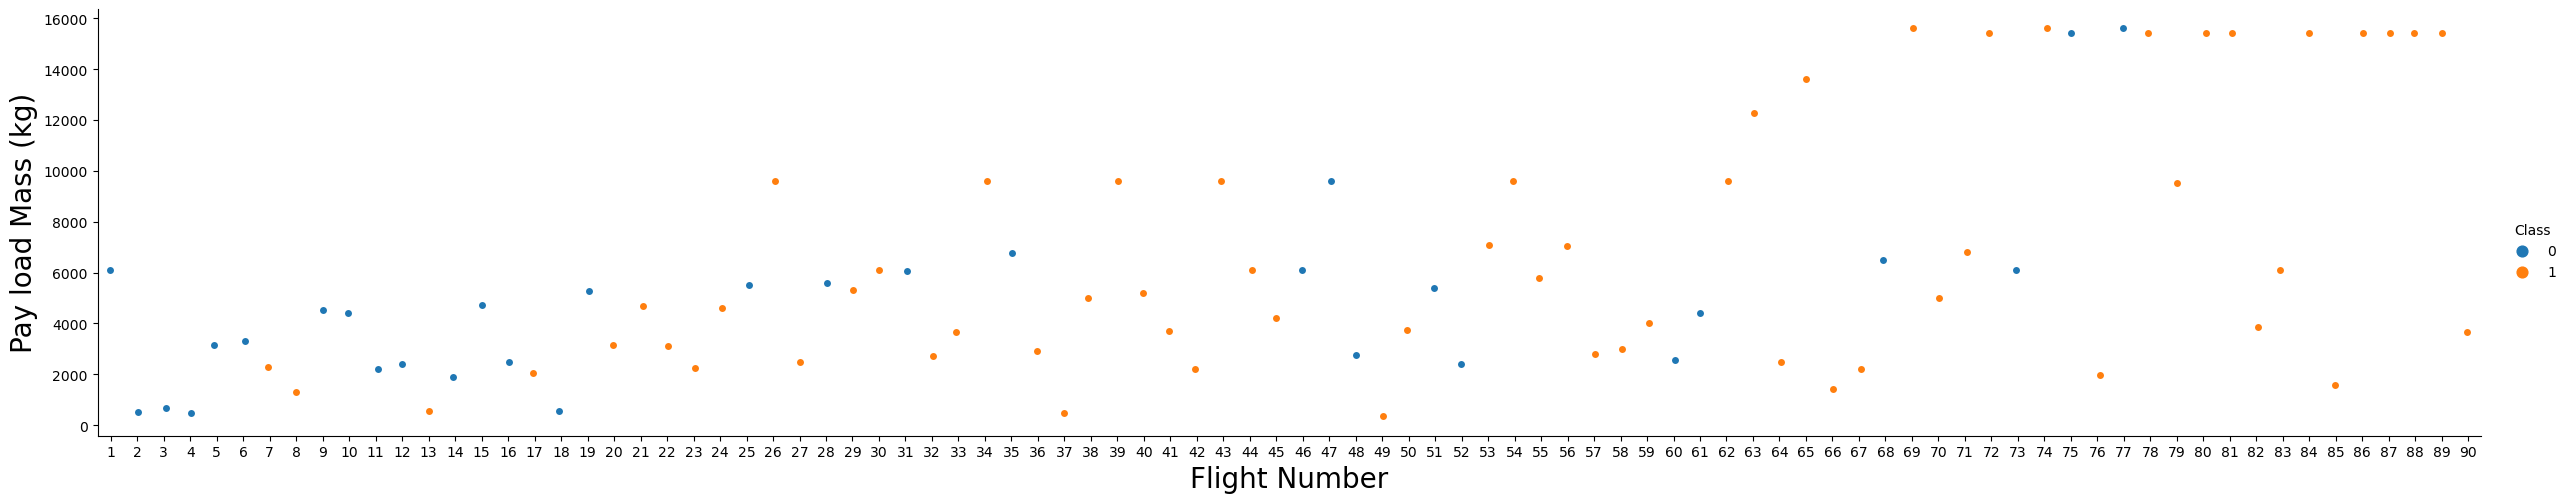

<Figure size 600x600 with 0 Axes>

In [68]:
sns.catplot(x="FlightNumber",y="PayloadMass", hue="Class", data=df2, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.figure(figsize=(6,6))
plt.show()

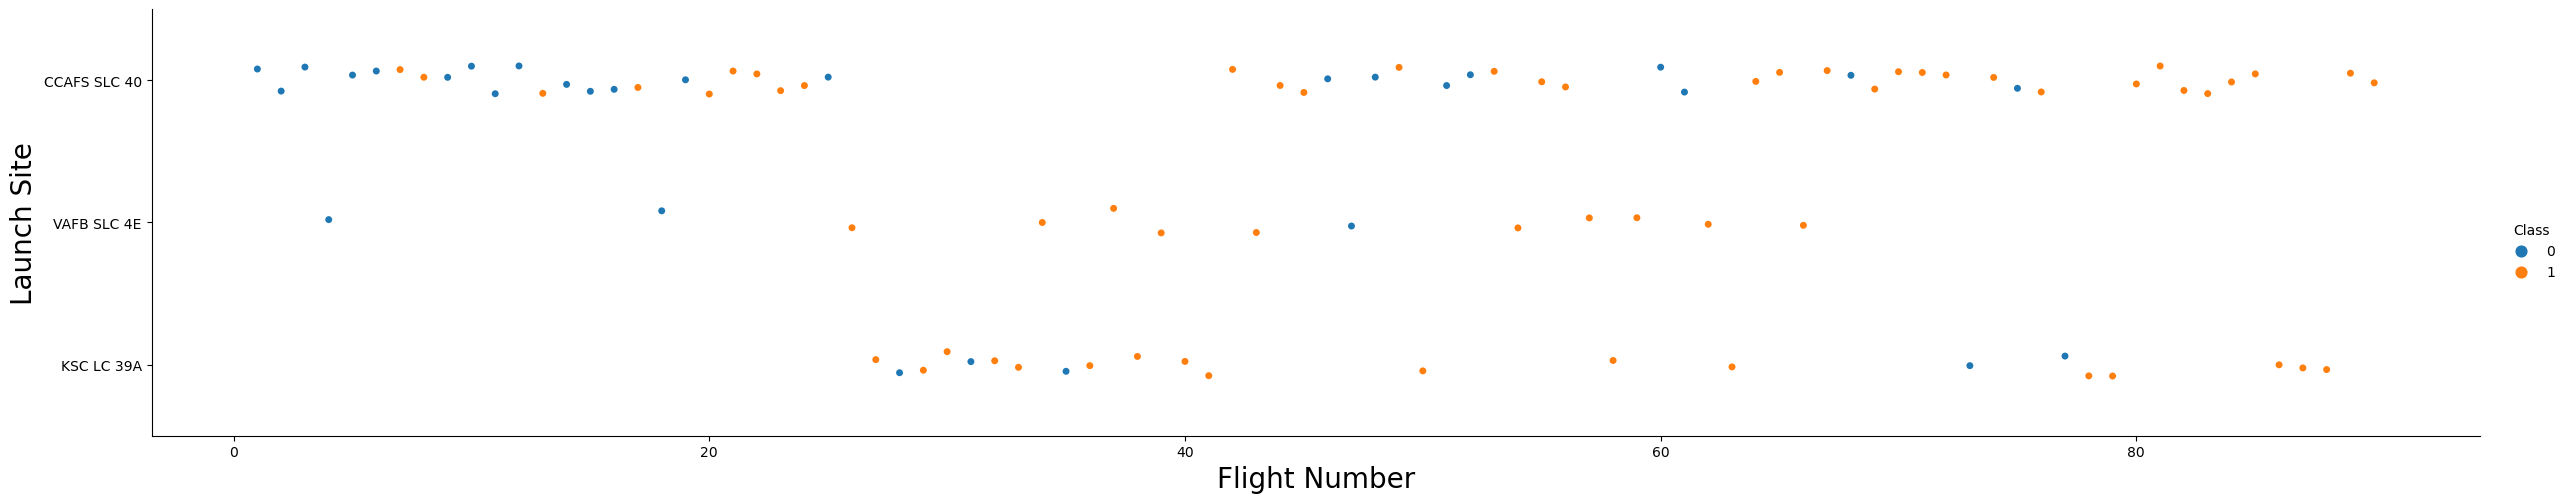

<Figure size 600x600 with 0 Axes>

In [69]:
#Use the function catplot to plot FlightNumber vs LaunchSite, set the parameter x parameter to FlightNumber,set the y to Launch Site and set the parameter hue to 'class'
#Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(x="FlightNumber",y="LaunchSite",  hue="Class", data=df2, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.figure(figsize=(6,6))
plt.show()

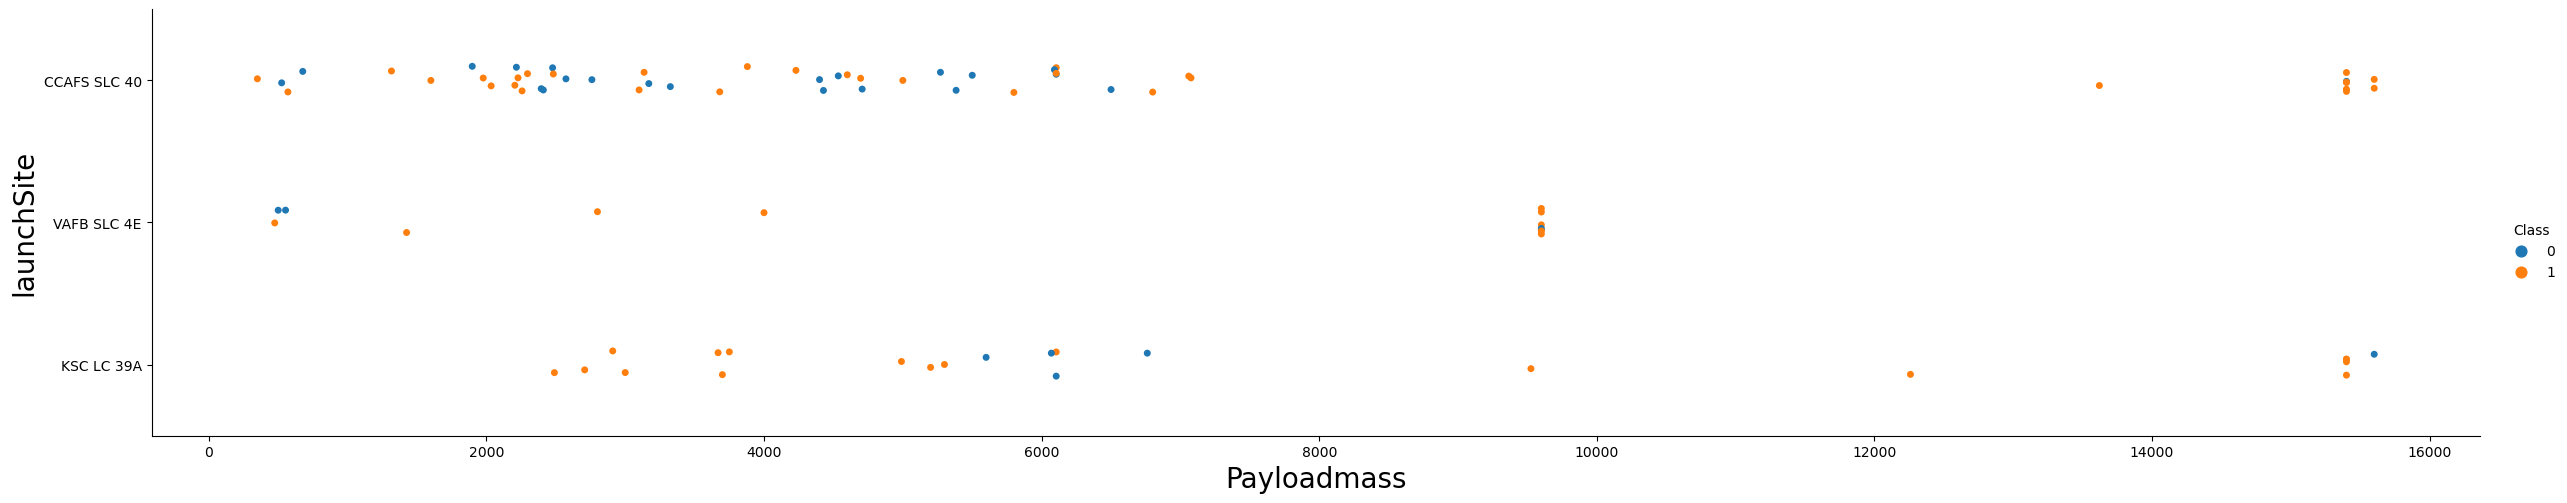

<Figure size 600x600 with 0 Axes>

In [70]:
#We also want to observe if there is any relationship between launch sites and their payload mass.
#Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(x="PayloadMass",y="LaunchSite", hue="Class", data=df2, aspect = 5)
plt.xlabel("Payloadmass",fontsize=20)
plt.ylabel("launchSite",fontsize=20)
plt.figure(figsize=(6,6))
plt.show()

In [71]:
#we want to visually check if there are any relationship between success rate and orbit type.
#HINT use groupby method on Orbit column and get the mean of Class column
df2.to_sql("spacexd2",con,if_exists='replace',index=False,method='multi')

In [72]:
%sql select count(Orbit)as orbit_count ,orbit,avg(Class) as mean_Class from spacexd2\
group by Orbit 

 * sqlite:///FinalDB.db
Done.


orbit_count,Orbit,mean_Class
1,ES-L1,1.0
1,GEO,1.0
27,GTO,0.5185185185185185
1,HEO,1.0
21,ISS,0.6190476190476191
7,LEO,0.7142857142857143
3,MEO,0.6666666666666666
9,PO,0.6666666666666666
1,SO,0.0
5,SSO,1.0


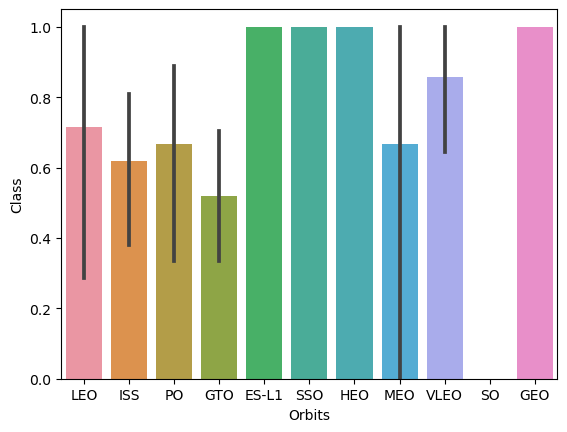

In [73]:
sns.barplot(x="Orbit",y="Class",data=df2)
plt.xlabel("Orbits")
plt.ylabel("Class")
plt.show()

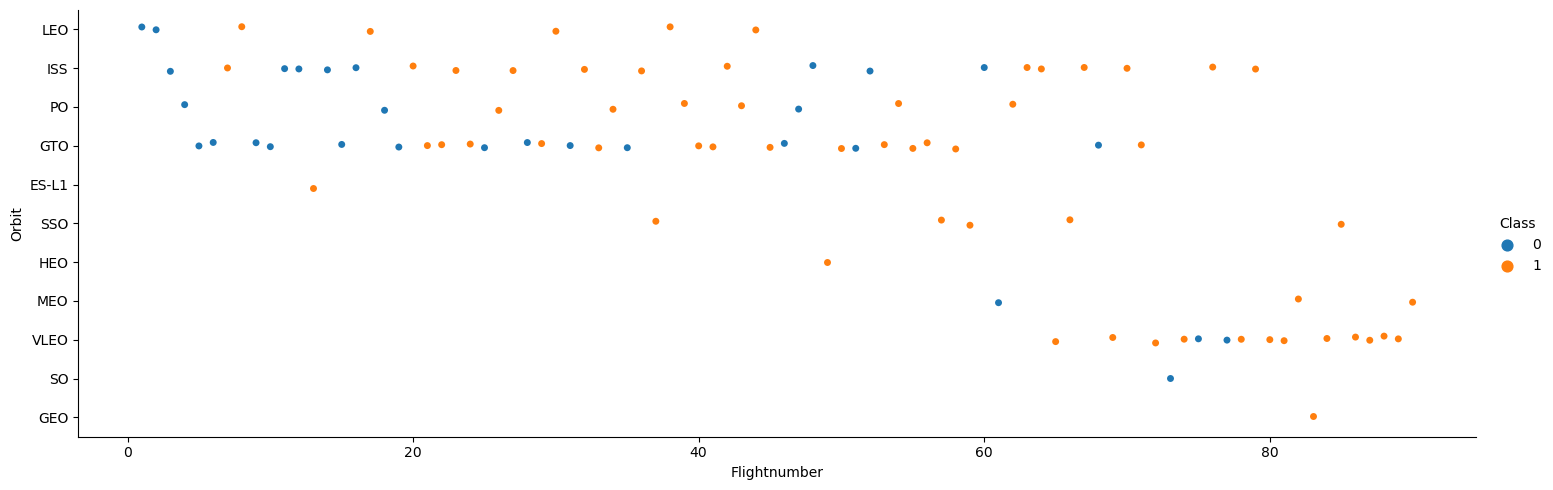

In [74]:
#we want to see if there is any relationship between FlightNumber and Orbit type
#Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit",x="FlightNumber",data=df2,hue="Class",aspect=3)
plt.ylabel("Orbit")
plt.xlabel("Flightnumber")
plt.show()

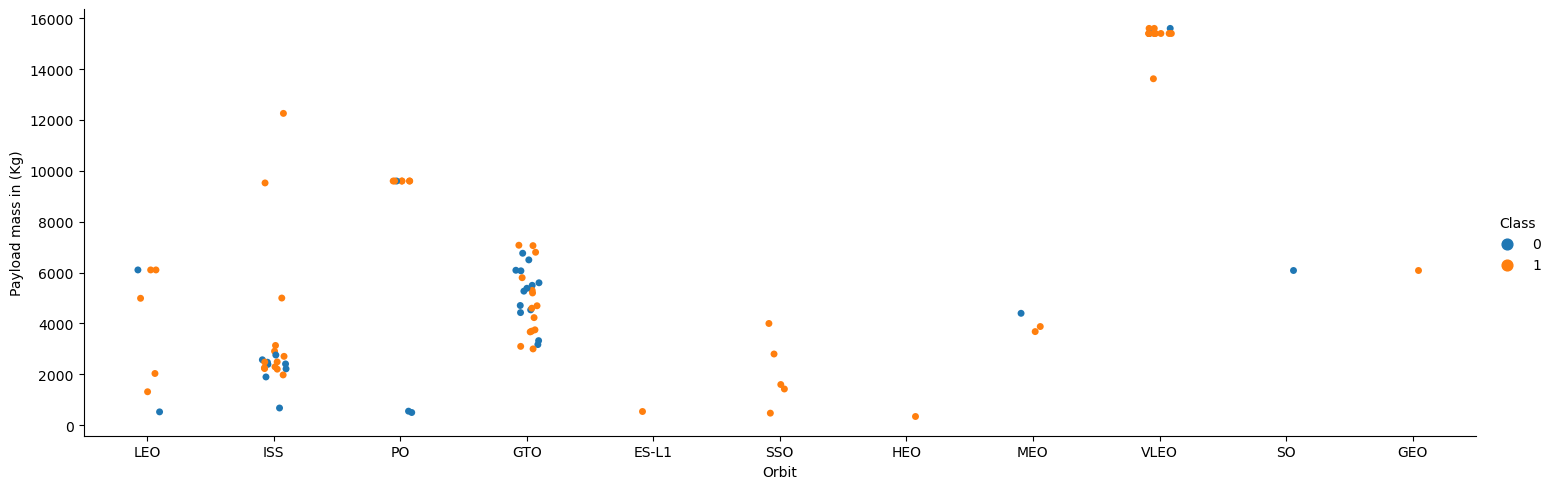

In [75]:
#we can plot the Payload vs. Orbit scatter point charts to reveal the relationship between Payload and Orbit type
#Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value

sns.catplot(y="PayloadMass",x="Orbit",hue="Class",data=df2,aspect=3)
plt.ylabel("Payload mass in (Kg)")
plt.xlabel("Orbit")
plt.show()

In [76]:
#You can plot a line chart with x axis to be Year and y axis to be average success rate, to get the average launch success trend.
# A function to Extract years from the date 
year_ext=[]
def Extract_year():
    for i in df["Date"]:
        year_ext.append(i.split("-")[0])
    return 0
Extract_year()

0

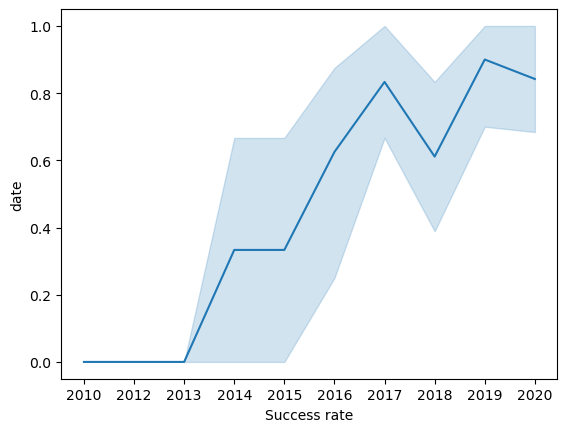

In [77]:
sns.lineplot(x=year_ext,y="Class",data=df2)
plt.ylabel("date")
plt.xlabel("Success rate")
plt.show()

In [78]:
df["Date"]

0     2010-06-04
1     2012-05-22
2     2013-03-01
3     2013-09-29
4     2013-12-03
         ...    
85    2020-09-03
86    2020-10-06
87    2020-10-18
88    2020-10-24
89    2020-11-05
Name: Date, Length: 90, dtype: object

In [79]:
df["Date"][4:][:4]

4    2013-12-03
5    2014-01-06
6    2014-04-18
7    2014-07-14
Name: Date, dtype: object

In [80]:
#setting required features as a dataframe
features = df2[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head(10)

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004
5,6,3325.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1005
6,7,2296.000000,ISS,CCAFS SLC 40,1,False,False,True,NaN,1.0,0,B1006
7,8,1316.000000,LEO,CCAFS SLC 40,1,False,False,True,NaN,1.0,0,B1007
8,9,4535.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1008
9,10,4428.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1011


In [81]:
pd.get_dummies(df2, columns=['Orbit', 'LaunchSite','LandingPad', 'Serial'], drop_first=True)

,FlightNumber,Date,BoosterVersion,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,Block,ReusedCount,Longitude,Latitude,Class,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,2010-06-04,Falcon 9,6104.959412,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2012-05-22,Falcon 9,525.000000,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2013-03-01,Falcon 9,677.000000,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2013-09-29,Falcon 9,500.000000,False Ocean,1,False,False,False,1.0,0,-120.610829,34.632093,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2013-12-03,Falcon 9,3170.000000,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,2020-09-03,Falcon 9,15400.000000,True ASDS,2,True,True,True,5.0,2,-80.603956,28.608058,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
86,87,2020-10-06,Falcon 9,15400.000000,True ASDS,3,True,True,True,5.0,2,-80.603956,28.608058,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
87,88,2020-10-18,Falcon 9,15400.000000,True ASDS,6,True,True,True,5.0,5,-80.603956,28.608058,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
88,89,2020-10-24,Falcon 9,15400.000000,True ASDS,3,True,True,True,5.0,2,-80.577366,28.561857,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [82]:
# HINT: Use get_dummies() function on the categorical columns
features_one_hot = pd.get_dummies(df2, columns=['Orbit', 'LaunchSite','LandingPad', 'Serial'], drop_first=False)
features_one_hot.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,Block,ReusedCount,Longitude,Latitude,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,2010-06-04,Falcon 9,6104.959412,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2012-05-22,Falcon 9,525.000000,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2013-03-01,Falcon 9,677.000000,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2013-09-29,Falcon 9,500.000000,False Ocean,1,False,False,False,1.0,0,-120.610829,34.632093,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2013-12-03,Falcon 9,3170.000000,None None,1,False,False,False,1.0,0,-80.577366,28.561857,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
#Now that our features_one_hot dataframe only contains numbers cast the entire dataframe to variable type float64
# HINT: use astype function
## WEIRD
features_one_hot = features_one_hot.astype('float64', errors='ignore')

In [84]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

## Data Visualization with Folium(Interactive)

In [85]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [86]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)

100% [................................................................................] 7710 / 7710

In [87]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610746


In [88]:
#Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites.
#If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [89]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>NASA JSC</b></div>',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [90]:
launch_sites_df.head()

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610746


In [91]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for ix, row in launch_sites_df.iterrows():
    ls_name = row['Launch Site']
    ls_lat  = row['Lat']
    ls_long = row['Long']
    
    #print('{}\t{}\t{}'.format(ls_name, ls_lat, ls_long))
    
    coordinate = [ls_lat, ls_long]
    circle = folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(ls_name + ' region'))
    marker = folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='%s' % ls_name, ))
    
    site_map.add_child(circle)
    site_map.add_child(marker)
    
site_map

### Mark the success/failed launches for each site on the map

In [92]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


#### Next, let's create markers for all launch records. If a launch was successful (class=1), then we use a green marker and if a launch was failed, we use a red marker (class=0)

##### Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate

In [93]:
#Let's first create a MarkerCluster object
marker_cluster = MarkerCluster()

In [94]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [95]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    ls_name = record['Launch Site']
    ls_lat  = record['Lat']
    ls_long = record['Long']
    coordinate = [ls_lat, ls_long]
    
    #rint('{}\t{}\t{}'.format(ls_name, ls_lat, ls_long))
        
    # TODO: Create and add a Marker cluster to the site map
    # marker = folium.Marker(...)
    marker = folium.map.Marker(coordinate, icon=folium.Icon(color='white', icon_color=record['marker_color'],icon_anchor=(0,0), html='%s' % ls_name))
    marker_cluster.add_child(marker)

site_map

## Calculate the distances between a launch site to its proximities

In [96]:
#Let's first add a MousePosition on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

#### Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.

#### You can calculate the distance between two points on the map based on their Lat and Long values using the following method:

In [97]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

#### TODO: Mark down a point on the closest railway using MousePosition and calculate the distance between the railway point to the launch site.

In [98]:
# find coordinate of railway point
# distance_railway = calculate_distance(launch_site_lat, launch_site_lon, raiwaly_lat, raiwaly_lon)
distance = calculate_distance(28.57468,-80.65229,28.573255 ,-80.646895)
distance

0.5503149993453544

#### TODO: After obtained its coordinate, create a folium.Marker to show the distance

In [99]:
# Create and add a folium.Marker on your selected closest railway point on the map
# Display the distance between railway point and launch site using the icon property 
# for example
coordinate = [28.57468,-80.65229]
distance_marker = folium.Marker(
    coordinate,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance),))
site_map.add_child(distance_marker)
site_map

## TODO: Draw a PolyLine between a launch site to the selected

In [100]:
# Create a `folium.PolyLine` object using the railway point coordinate and launch site coordinate
coordinates=[[28.57468,-80.65229],[28.573255 ,-80.646895]]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

## TODO: Similarly, you can draw a line betwee a launch site to its closest city, coastline, highway, etc.

In [101]:
# Create a marker with distance to a closest city, coastline, highway, etc.
# Draw a line between the marker to the launch site
coordinates=[[28.52361, -80.64857],[28.573255 ,-80.646895]]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

distance_marker = folium.Marker(
    coordinates[0],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(calculate_distance(28.52361, -80.64857,28.573255 ,-80.646895)),))
site_map.add_child(distance_marker)

## Predictive Analysis

In [102]:
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

#### This function is to plot the confusion matrix.

In [103]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

### Load the data

In [104]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

data.head(7)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857,0
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857,1


In [105]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X.head(100)

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

### TASK 1
#### Create a NumPy array from the column Class in data, by applying the method to_numpy() then assign it to the variable Y,make sure the output is a Pandas series (only one bracket df['name of column']).

In [ ]:
Y=np.array(data['Class'].to_numpy())

In [ ]:
Y

### TASK 2
#### Standardize the data in X then reassign it to the variable X using the transform provided below.

In [ ]:
# students get this 
transform = preprocessing.StandardScaler()

In [ ]:
X=transform.fit(X).transform(X.astype(float))

In [ ]:
X[0:2]

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=2)

In [ ]:
ytest.shape

### TASK 4
#### Create a logistic regression object then create a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [ ]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters)
logreg_cv.fit(xtrain, ytrain)

#### We output the GridSearchCV object for logistic regression. We display the best parameters using the data attribute best_params_ and the accuracy on the validation data using the data attribute best_score_.

In [ ]:
print("tuned hpyerparameters :(best parameters):\n",logreg_cv.best_params_)
print("accuracy :\n",logreg_cv.best_score_)

### TASK 5
#### Calculate the accuracy on the test data using the method score:

In [ ]:
print("accuracy :",logreg_cv.score(xtest, ytest))

#### Lets look at the confusion matrix:

In [ ]:
yhat=logreg_cv.predict(xtest)

In [ ]:
plot_confusion_matrix(ytest,yhat)
plt.show()

### TASK 6
#### Create a support vector machine object then create a GridSearchCV object svm_cv with cv - 10. Fit the object to find the best parameters from the dictionary parameters.

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [ ]:
svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters)
svm_cv.fit(xtrain, ytrain)

In [ ]:
print("tuned hpyerparameters :\n(best parameters) :\n",svm_cv.best_params_)
print("accuracy :\n",svm_cv.best_score_)

### TASK 7
#### Calculate the accuracy on the test data using the method score:

In [ ]:
print("accuracy :", svm_cv.score(xtest, ytest))

In [ ]:
#Confusion matrix
yhat=svm_cv.predict(xtest)
plot_confusion_matrix(ytest,yhat)
plt.show()

### TASK 8
#### Create a decision tree classifier object then create a GridSearchCV object tree_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [ ]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [ ]:
tree_cv=GridSearchCV(estimator=tree,param_grid=parameters,cv=10)


In [ ]:
tree_cv.fit(xtrain,ytrain)

In [ ]:
print("tuned hyperparameters: \n(best parameters): ",tree_cv.best_params_)
print("accuracy :\n",tree_cv.best_score_)

### TASK 9
#### Calculate the accuracy of tree_cv on the test data using the method score:

In [ ]:
print("accuracy :", tree_cv.score(xtest, ytest))

#### We can plot the confusion matrix

In [ ]:
yhat = tree_cv.predict(xtest)
plot_confusion_matrix(ytest,yhat)
plt.show()

### TASK 10
#### Create a k nearest neighbors object then create a GridSearchCV object knn_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [ ]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [ ]:
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters)
knn_cv.fit(xtrain, ytrain)

In [ ]:
print("tuned hpyerparameters :\n(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

### TASK 11
#### Calculate the accuracy of tree_cv on the test data using the method score:

In [ ]:
print("accuracy :", knn_cv.score(xtest, ytest))

#### We can plot the confusion matrix

In [ ]:
yhat = knn_cv.predict(xtest)
plot_confusion_matrix(ytest,yhat)
plt.show()

### TASK 12
#### Find the method performs best:

In [ ]:

print("Model\t\tAccuracy\tTestAccuracy")#,logreg_cv.best_score_)
print("LogReg\t\t{}\t\t{}".format((logreg_cv.best_score_).round(5), logreg_cv.score(xtest, ytest).round(5)))
print("SVM\t\t{}\t\t{}".format((svm_cv.best_score_).round(5), svm_cv.score(xtest, ytest).round(5)))
print("Tree\t\t{}\t\t{}".format((tree_cv.best_score_).round(5), tree_cv.score(xtest, ytest).round(5)))
print("KNN\t\t{}\t\t{}".format((knn_cv.best_score_).round(5), knn_cv.score(xtest, ytest).round(5)))

comparison = {}

comparison['LogReg'] = {'Accuracy': logreg_cv.best_score_.round(5), 'TestAccuracy': logreg_cv.score(xtest, ytest).round(5)}
comparison['SVM'] = {'Accuracy': svm_cv.best_score_.round(5), 'TestAccuracy': svm_cv.score(xtest, ytest).round(5)}
comparison['Tree'] = {'Accuracy': tree_cv.best_score_.round(5), 'TestAccuracy': tree_cv.score(xtest, ytest).round(5)}
comparison['KNN'] = {'Accuracy': knn_cv.best_score_.round(5), 'TestAccuracy': knn_cv.score(xtest, ytest).round(5)}

In [ ]:
x = []
y1 = []
y2 = []

for meth in comparison.keys():
    x.append(meth)    
    y1.append(comparison[meth]['Accuracy'])
    y2.append(comparison[meth]['TestAccuracy'])
    
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, y1, 0.4, label = 'Accuracy')
plt.bar(x_axis + 0.2, y2, 0.4, label = 'Test Accuracy')

plt.ylim([0,1])
plt.xticks(x_axis, x)

plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.title("Accuracy of Each Method")
plt.legend(loc='lower left')
plt.show()